# Lab 04: Hồi quy tuyến tính

- Họ tên: Nguyễn Tường Bách Hỷ
- MSSV: 22120455

<font color='red'>**LƯU Ý:**</font>

- Bài làm của sinh viên phải do chính bản thân sinh viên tự làm, có thể trao đổi và tham khảo ý tưởng nhưng không được sao chép (một phần hoặc toàn bộ) code hoặc lời giải từ bất cứ người nào khác. Nếu vi phạm sẽ bị <font color='red'>0đ</font> bài tập này.
- Các bạn có thể tạo thêm các cell trong quá trình code, tuy nhiên các bạn vui lòng <font color='red'>không xóa các cell code mặc định và các cell test case</font> (vì có thể ảnh hưởng đến kết quả khi chấm bài).
- Các test case được đưa ra chỉ nhằm mục đích giúp các bạn test code của mình, <font color='red'>**việc pass các test case này không đồng nghĩa với việc lời giải của các bạn sẽ đạt điểm tối đa**</font>. 

**Cách làm bài**


Bạn sẽ làm trực tiếp trên file notebook này; trong file, từ `TODO` để cho biết những phần mà bạn cần phải làm.

**Cách nộp bài**

Khi chấm bài, đầu tiên mình sẽ chọn `Kernel` - `Restart Kernel & Run All Cells`, để restart và chạy tất cả các cell trong notebook của các bạn; do đó, trước khi nộp bài, các bạn nên chạy thử `Kernel` - `Restart Kernel & Run All Cells` để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, các bạn tạo thư mục nộp bài theo cấu trúc sau:

- Thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - File `HW04.ipynb` (Đổi tên file notebook này theo MSSV của bạn)

Cuối cùng, các bạn nén thư mục `MSSV` này lại và nộp ở link trên moodle. **Đuôi của file nén phải là .zip (chứ không được .rar hay gì khác).**

<font color=red>Các bạn lưu ý tuân thủ chính xác qui định nộp bài ở trên.</font>

**Nội dung bài tập**

Bài tập 4 là bài tập cá nhân. Trong bài này, bạn sẽ cài đặt thuật toán học máy: 
1. Hồi quy tuyến tính (Linear Regression)
2. Hồi quy đa thức/ phi tuyến (Polynominal Regression)

### Tải những thư viện cần thiết

In [246]:

import os
from zlib import adler32
from typing import Tuple, List
import requests
import shutil
import random

import scipy
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

In [247]:
# Init seed
seed = 2024
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Tải tập dữ liệu

In [248]:
def read_data(data_file):
    X, Y = [], []

    with open(data_file, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        values = line.split(' ')
        x_value = float(values[0])
        y_value = float(values[1])

        X.append(x_value)
        Y.append(y_value)

    return np.array([np.array(X)]).T, np.array(np.array(Y)).T


train_X, train_y = read_data('train.txt')
new_X, new_y = read_data('new.txt')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of new_X:   {new_X.shape}, shape of new_y:   {new_y.shape}')

Shape of train_X: (100, 1), shape of train_y: (100,)
Shape of new_X:   (100, 1), shape of new_y:   (100,)


In [249]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')
print(f'Min of train_y: {train_y.min()}, max of train_y: {train_y.max()}')

Min of train_X: -0.994303, max of train_X: 0.991876
Min of train_y: -1.0, max of train_y: 0.956107


In [250]:
# TEST

SP = train_X.shape + new_X.shape + train_y.shape + new_y.shape

assert adler32(str(SP).encode()) == 1008338036

## Hồi quy tuyến tính

In [251]:
def RMSE(y, ypred):
    rmse = np.sqrt(np.mean((y-ypred)**2))
    return rmse

Xem biểu đồ tương quan giữa biến độc lập và biến phụ thuộc.

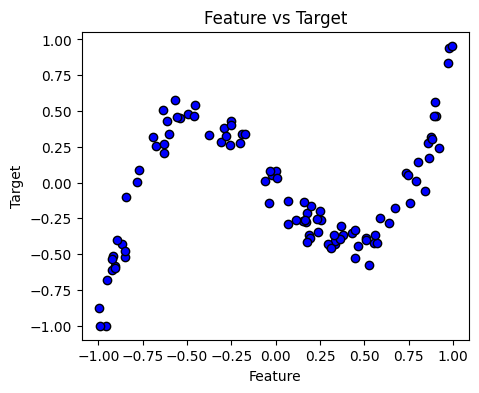

In [252]:
# Create a figure and two subplots
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

# Scatter plot for the first feature
axs.scatter(train_X, train_y, color='blue', edgecolors='k')
axs.set_xlabel('Feature')
axs.set_ylabel('Target')
axs.set_title('Feature vs Target')

# Display the plots
plt.show()

Dựa trên hình ảnh trực quan hóa, ta có thể sử dụng mô hình hồi quy để mô hình hóa quan hệ giữa các features, với target. Xem xét dạng của bài toán hồi quy tuyến tính như sau:

$$
y = \boldsymbol x^T\boldsymbol\theta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
trong đó $\boldsymbol x\in\mathbb{R}^D$ là biến phụ thuộc (đầu vào) và $y\in\mathbb{R}$ là các quan sát bị nhiễu. Vector tham số $\boldsymbol\theta\in\mathbb{R}^D$ tham số hóa hàm tuyến tính này.

Giả sử có tập huấn luyện $(\boldsymbol x_n, y_n)$, $n=1,\ldots, N$. Ta hình thức hóa các bộ dữ liệu đầu vào huấn luyện theo thứ tự $\mathcal X = \{\boldsymbol x_1, \ldots, \boldsymbol x_N\}$ và các mục tiêu huấn luyện tương ứng $\mathcal Y = \{y_1, \ldots, y_N\}$.

### Triển vọng cực đại

Phương pháp ước tính triển vọng cực đại của các tham số $\boldsymbol\theta$. Trong ước tính triển vọng cực đại, các tham số $\boldsymbol\theta^{\mathrm{ML}}$ cực đại hóa likelihood

$$
p(\mathcal Y | \mathcal X, \boldsymbol\theta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\theta)\,.
$$

Giải bài toán tối ưu, nghiệm thu được là:

$$
\boldsymbol\theta^{\text{ML}} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y\in\mathbb{R}^D\,,
$$
trong đó:
$$
\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^T\in\mathbb{R}^{N\times D}\,,\quad \boldsymbol y = [y_1, \ldots, y_N]^T \in\mathbb{R}^N\,.
$$

In [253]:
def MLE(X, y):
    """Hàm ước lượng triển vọng cực đại

    Parameters
    ----------
    X
        N x D ma trận dữ liệu huấn luyện đầu vào
    y
        N x 1 vector của mục tiêu huấn luyện/ quan sát huấn luyện

    Returns
    -------
        tham số triển vọng cực đại (D x 1)
    """
    theta_ml = np.linalg.inv(X.T@X)@X.T@y 
    theta_ml = np.linalg.solve(X.T @ X, X.T @ y)
    return theta_ml

In [254]:
def predict_with_estimate(Xtest, theta):
    """_summary_

    Parameters
    ----------
    Xtest
        K x D ma trận dữ liệu kiểm tra
    theta
        D x 1 vector tham số

    Returns
    -------
        kết quả dự đoán f(Xtest); K x 1 vector
    """
    prediction = Xtest@theta
    return prediction

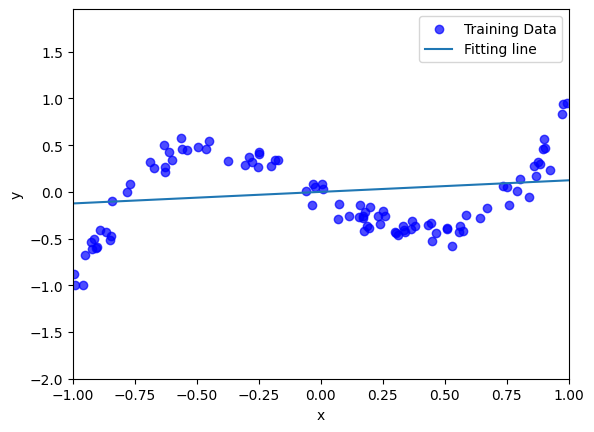

In [255]:
# Tính toán ước lượng triển vọng cực đại
theta_ml = MLE(train_X, train_y)

# Dự đoán các giá trị hàm tại các điểm kiểm tra bằng bộ ước lượng triển vọng cực đại
mle_pred = predict_with_estimate(new_X, theta_ml)


# Trực quan
plt.scatter(train_X, train_y, color='blue', label='Training Data', alpha=0.7) 
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1); plt.ylim(-1, 1)

xx = np.linspace(-1, 1, 500).reshape(-1, 1)
yy = theta_ml[0] * xx
plt.plot(xx, yy, '-',label="Fitting line")
plt.xlim(-1, 1)
plt.ylim(min(train_y) - 1, max(train_y) + 1)
plt.legend()
plt.show()

In [256]:
# Đánh giá RMSE
RMSE(new_y, mle_pred)

0.4113825581491616

TODO: Bạn có nhận xét gì?

Mô hình huấn luyện được cho thấy không phù hợp với dữ liệu thực tế, thể hiện qua hiện tượng underfitting. Điều này xảy ra do mô hình chưa nắm bắt đầy đủ các cấu trúc cơ bản trong dữ liệu, dẫn đến hiệu năng dự đoán kém. Giá trị sai số toàn phương trung bình căn bậc hai (RMSE) cao (lớn hơn 0.4) là minh chứng cho các sai số dự đoán lớn, phản ánh khả năng mô hình hóa chưa đạt yêu cầu.

Để cải thiện mô hình, ta có thể xem xét việc tăng thêm tham số cho mô hình hoặc những mô hình nonlinear regression.

Ta sẽ thêm một bias vào mô hình để nó linh hoạt hơn.

$$
y = \theta_0 + \boldsymbol x^T \boldsymbol\theta_1 + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)
$$

Định nghĩa:

$$\boldsymbol x_{\text{aug}} = \begin{bmatrix}1\\\boldsymbol x\end{bmatrix}$$

Ta viết lại phương trình mô hình hồi quy tuyến tính:

$$
y = \boldsymbol x_{\text{aug}}^T\boldsymbol\theta_{\text{aug}} + \epsilon\,,\quad \boldsymbol\theta_{\text{aug}} = \begin{bmatrix}
\theta_0\\
\boldsymbol\theta_1
\end{bmatrix}\,.
$$

In [257]:
def add_ones(X):
    one_columns = np.ones((X.shape[0], 1))
    return np.hstack((one_columns, X))

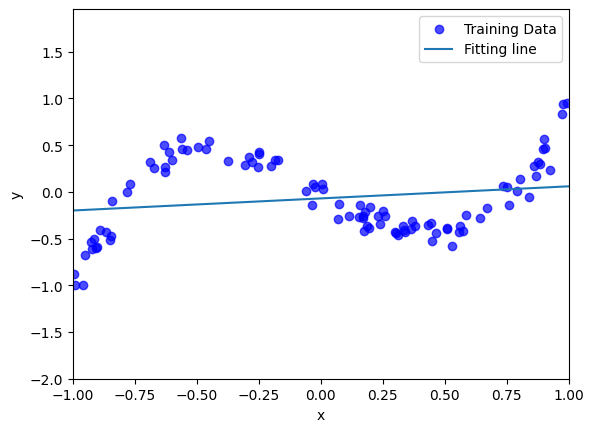

In [258]:
# Thêm bias vào data (cột đầu tiên full 1)
X_aug = add_ones(train_X)

# Tính toán ước lượng triển vọng cực đại
theta_ml = MLE(X_aug, train_y)

# Dự đoán các giá trị hàm tại các điểm kiểm tra bằng bộ ước lượng triển vọng cực đại
mle_pred = predict_with_estimate(X_aug, theta_ml)

# Trực quan
plt.scatter(train_X, train_y, color='blue', label='Training Data', alpha=0.7) 
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1); plt.ylim(-1, 1)

xx = np.linspace(-1, 1, 500).reshape(-1, 1)
yy = theta_ml[0] + theta_ml[1] * xx
plt.plot(xx, yy, '-',label="Fitting line")
plt.xlim(-1, 1)
plt.ylim(min(train_y) - 1, max(train_y) + 1)
plt.legend()
plt.show()

In [259]:
# Đánh giá RMSE
RMSE(new_y, mle_pred)

0.4245400631581529

TODO: Bạn có nhận xét gì?

Mô hình hiện tại cho giá trị sai số toàn phương trung bình căn bậc hai (RMSE) lớn hơn so với mô hình trước đó, cho thấy hiệu năng dự đoán của nó kém hơn. Điều này cũng phản ánh rằng mô hình chưa nắm bắt đủ các đặc trưng cơ bản của dữ liệu, dẫn đến hiện tượng underfitting. Vì vậy, mô hình này không phù hợp cho bài toán và cần được cải thiện thông qua việc tăng thêm biến cho mô hình hoặc sử dụng những mô hình phức tạp hơn như nonlinear regression.

### Phi tuyến hóa hồi quy tuyến tính 

Ta hoàn toàn có thể khớp các hàm phi tuyến tính trong đầu vào $\boldsymbol x$, miễn là các tham số $\boldsymbol\theta$ xuất hiện tuyến tính. Điều này có nghĩa là, chúng ta có thể học các hàm có dạng:

$$
f(\boldsymbol x, \boldsymbol\theta) = \sum_{k = 1}^K \theta_k \phi_k(\boldsymbol x)\,,
$$
trong đó các đặc trưng $\phi_k(\boldsymbol x)$ là các phép biến đổi (có thể phi tuyến tính) của các đầu vào $\boldsymbol x$.

Một trong những loại hàm thường hay sử dụng đó là hàm đa thức bậc $K$, ta viết

$$
\sum_{k=0}^K \theta_k x^k = \boldsymbol \phi(x)^T\boldsymbol\theta\,,\quad
\boldsymbol\phi(x)= 
\begin{bmatrix}
x^0\\
x^1\\
\vdots\\
x^K
\end{bmatrix}\in\mathbb{R}^{K+1}\,.
$$
Ở đây, $\boldsymbol\phi(x)$ là phép biến đổi đặc trưng phi tuyến tính của các đầu vào $x\in\mathbb{R}$.

Từ đó, tập huấn luyện sau khi biến đổi có dạng:
$$
\boldsymbol\Phi = \begin{bmatrix}
\boldsymbol\phi(x_1) & \boldsymbol\phi(x_2) & \cdots & \boldsymbol\phi(x_n)
\end{bmatrix}^T \in\mathbb{R}^{N\times K+1}
$$

In [260]:
def poly_features(X, K):
    """tính toán ma trận đặc trưng Phi (N x (K+1))

    Parameters
    ----------
    X
        đầu vào có kích thước N x 1
    k
        bậc của đa thức

    Returns
    -------
        tính toán ma trận đặc trưng Phi (N x (K+1))
    """

    columns = []

    for k in range(K + 1):
        column = X**k
        columns.append(column)

    return np.hstack(columns)


Nghiệm tối ưu

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$

Nghiệm tối ưu (+tối ưu tính toán số học)

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi + \kappa\boldsymbol I)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$

In [261]:
def nonlinearMLE(Phi, y):
    """Non-linear MLE

    Parameters
    ----------
    Phi
        ma trận đặc trưng cho dữ liệu đầu vào. Kích thước N x (K+1)
    y
        các mục tiêu huấn luyện. Kích thước N x 1

    Returns
    -------
        bộ ước lượng triển vọng cực đại theta_ml. Kích thước D x 1
    """
    
    kappa = 1e-08 # 'jitter' term; nhằm mục tiêu tối ưu tính toán số học
    
    K = Phi.shape[1]

    theta_ml = np.linalg.solve(Phi.T @ Phi + kappa * np.eye(K), Phi.T @ y)

    return theta_ml

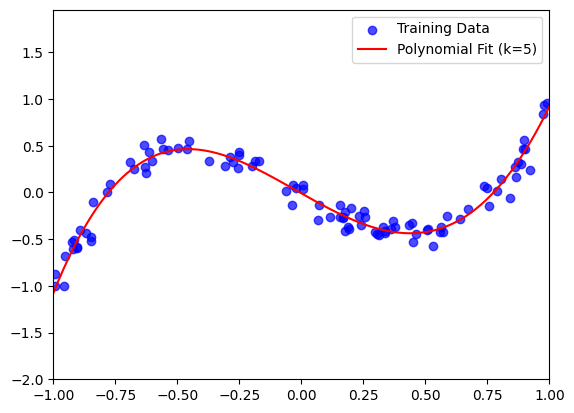

In [262]:
k = 5 # Định nghĩa bậc đa thức mà ta muốn khớp

phiX = poly_features(train_X, k) # N x (K+1) ma trận đặc trưng

poly_theta_ml = nonlinearMLE(phiX, train_y) # bộ ước lượng triển vọng cực đại

mle_pred = predict_with_estimate(poly_features(new_X, k), poly_theta_ml)

# Trực quan
plt.scatter(train_X, train_y, color='blue', label='Training Data', alpha=0.7) 
xx = np.linspace(-1, 1, 500).reshape(-1, 1)
xx_phi = poly_features(xx, k)
yy = predict_with_estimate(xx_phi, poly_theta_ml)
plt.plot(xx, yy, color='red', label=f'Polynomial Fit (k={k})')
plt.xlim(-1, 1)
plt.ylim(min(train_y) - 1, max(train_y) + 1)
plt.legend()
plt.show()

In [263]:
# Đánh giá RMSE
RMSE(new_y, mle_pred)

0.0968269727036068

TODO: Bạn có nhận xét gì?

Mô hình được xây dựng đã khớp tốt với dữ liệu huấn luyện, thể hiện qua giá trị sai số toàn phương trung bình căn bậc hai (RMSE) nhỏ, xấp xỉ 0.097. Điều này cho thấy mô hình có khả năng dự đoán tốt trên tập huấn luyện.